# Preprocessing

To begin the training process, the raw images first had to be preprocessed. For the most part, this meant removing the banners that contained image metadata while retaining as much useful image data as possible. To remove the banners, I used a technique called "reflective padding" which meant I remove the banner region, then pad the edges with its own reflection. An example of this is shown here:

In order to remove the banners, however, they must first be detected. This was done using kernels in OpenCV to detect vertical and horizontal lines within the image. For instance, let's say you start with this image:

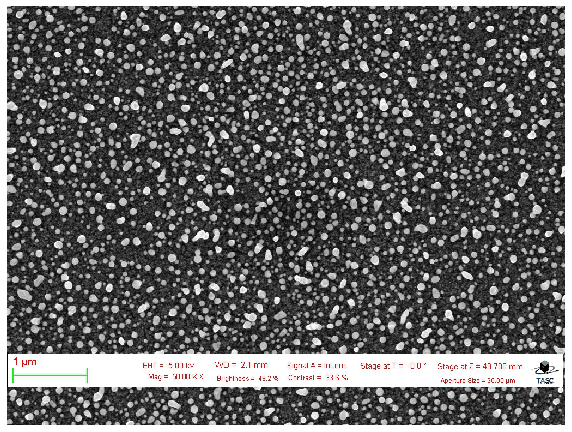

In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

file = '../data/Raw_Data/Particles/L2_000b4469b73e3fb3558d20b33b91fcb0.jpg'
img = mpimg.imread(file)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_axis_off()
ax.imshow(img)

The first step would be to create a binary mask of the image where all pixels above a threshold becomes 255 and all pixels below the threshold becomes 0. Since the banners in our images are mostly white, the threshold value chosen was 250. This is to ensure it is mostly only the banner that is left in the mask.

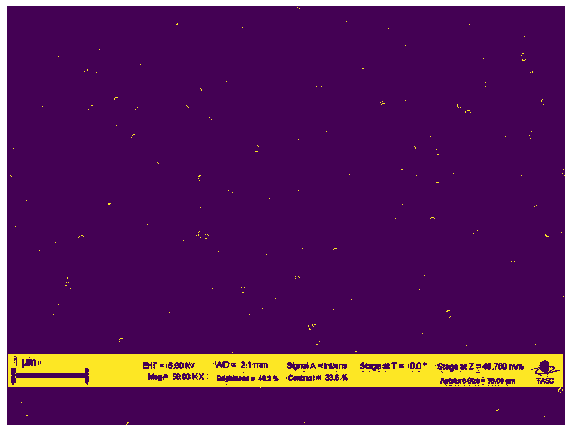

In [12]:
import cv2

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # binarization only works if the image is first converted to greyscale
ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY) # binarize the image using 250 as the threshold value
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_axis_off()
ax.imshow(thresh)

Next, use [erosion and dilation](https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html) to find where the vertical and horizontal lines are within the image. By successively replacing pixels with the minimum (erosion) then maximum value (dilation) over the area of a kernel, largely vertical regions of the image are maintained using a tall thin kernel while a short long kernel mantains the largely horizontal regions of the image.

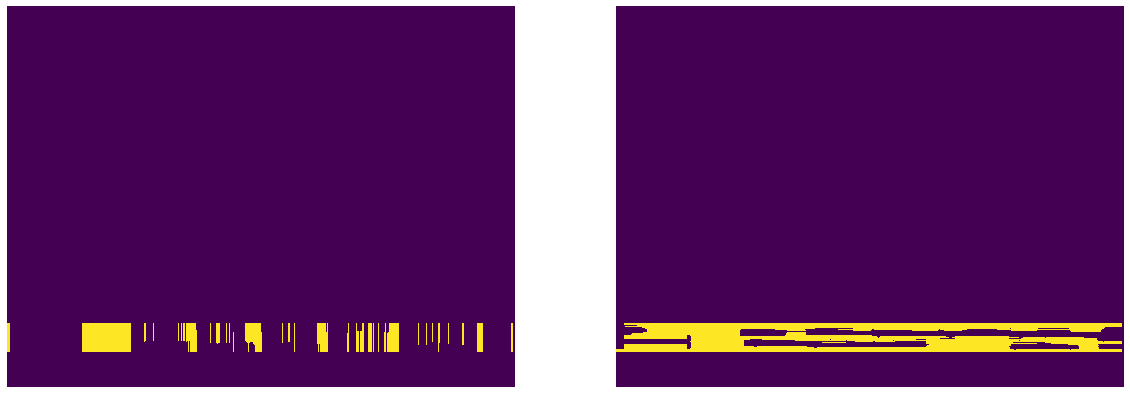

In [20]:
# Find the verticle and horizontal lines in the image
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 13))
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

img_v = cv2.erode(thresh, verticle_kernel, iterations = 3)
vert_lines_img = cv2.dilate(img_v, verticle_kernel, iterations = 3)    
img_h = cv2.erode(thresh, horizontal_kernel, iterations = 3)
hori_lines_img = cv2.dilate(img_h, horizontal_kernel, iterations = 3)

fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].set_axis_off()
ax[0].imshow(vert_lines_img)

ax[1].set_axis_off()
ax[1].imshow(hori_lines_img)

The two masks are then added together and a final erosion + binarization is performed on the inverted array to ensure we are left with a binary mask where pixel values of 0 indicate the banner region and pixel values of 255 indicate everywhere else.

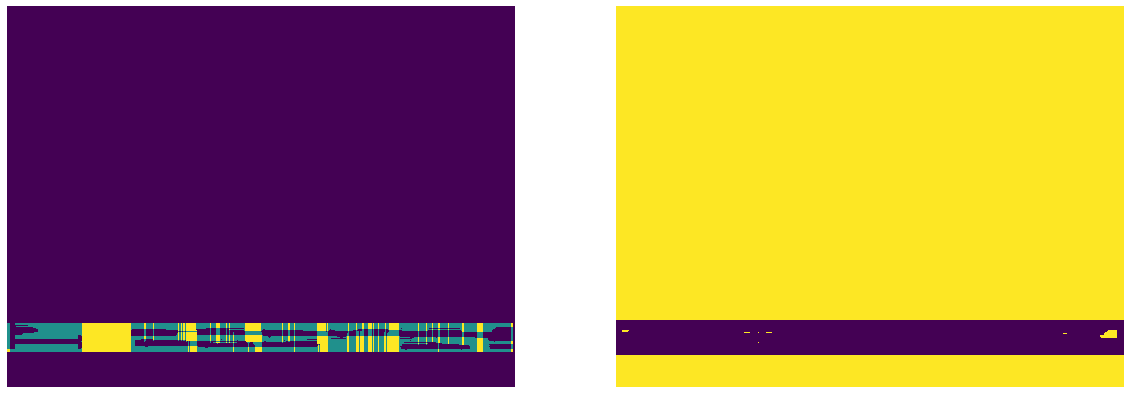

In [33]:
img_add = cv2.addWeighted(vert_lines_img, 0.5, hori_lines_img, 0.5, 0.0)

img_final = cv2.erode(~img_add, kernel, iterations = 3)
ret, thresh2 = cv2.threshold(img_final, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].set_axis_off()
ax[0].imshow(img_add)

ax[1].set_axis_off()
ax[1].imshow(thresh2)

In [25]:
img_final

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)